<a href="https://colab.research.google.com/github/christopherdiamana/Deep_Learning_TP_for_Vision/blob/main/VAE_Deepcourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Variational Auto-Encoder (VAE)</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://github.com/arthurdouillard/deepcourse/issues).

In [ ]:
%pylab inline

In [ ]:
import glob
import random

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as Fv
import torchvision
from PIL import Image

This colab is strongly inspired by the [Keras tutorial on VAE](https://keras.io/examples/generative/vae/).

In this colab, we are going to build a VAE for MNIST, and generate novel images of digits.

First, we load the dataset and create a loader:

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()  # Normalize image of range [0, 255] to [0, 1]
])


dataset = torchvision.datasets.MNIST(".", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

Always check that the data seems correct:

In [ ]:
x, y = next(iter(loader))
print(x.shape, y.shape)
print(x.min(), x.max())
print(torch.unique(y))

## What is our objective?

We want to estimate the posterior $p(z | x)$, aka what should be our hidden code $z$ given the input data $x$.

By **Bayes rule** we have $p(z | x) = \frac{p(x | z) p(z)}{p(x)} \propto \frac{p(x | z)}{p(x)}$.

NB: $p(z | x)$ is the posterior, $p(x | z)$ the likelihood, $p(z)$ the prior, and $p(x)$ the evidence.

But $p(x)$ is **untractable** (meaning we cannot easily compute it) because $p(x) = \int p(x | z) p(z) dz$. And with a high dimension enough $z$ we need to integrate over all dimensions.

So what to do? Two possible solutions:
- [Monte-carlo sampling](https://en.wikipedia.org/wiki/Monte_Carlo_method)
- And **Variational Inference** (VI)

We are going to do VI here.

Let's approximate $p(z | x)$ by a $q(z)$ a distribution we defined so it is tractable. Thus, we want to minimize a kind of distance (it's not *really* a distance) between those two distributions: use the [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL Div).

$$min\, KL(q(z) \Vert p(z | x)) = - \sum q(z) \log \frac{p(z | x)}{q(z)}$$

Because $p(z | x) = \frac{p(x | z) p(z)}{p(x)} = \frac{p(x, z)}{p(x)}$ by Bayes and then **rule of multiplication**. Then:

$$
\begin{equation}
\begin{split}
KL(q(z) \Vert p(z | x)) & = -\sum q(z)\log \frac{p(z | x)}{q(z)} \\
 & = -\sum q(z)\log \frac{\frac{p(x, z)}{p(x)}}{\frac{q(z)}{1}} \\
 & = -\sum q(z)\log \frac{p(x, z)}{q(z)} \cdot \frac{1}{p(x)} \\
 & = -\sum q(z) [\log \frac{p(x, z)}{q(z)} - \log p(x)] && \text{By the properties of log}\\
 & = -\sum q(z) \log \frac{p(x, z)}{q(z)} + \sum q(z) \log p(x) \\
 & = -\sum q(z) \log \frac{p(x, z)}{q(z)} + \log p(x) \sum q(z) \\
 & = -\sum q(z) \log \frac{p(x, z)}{q(z)} + \log p(x) && \text{Because a distribution sum to 1} \\
\end{split}
\end{equation}
$$

Thus considering our original KL:

$$\log p(x) = KL(q(z) \Vert p(z | x)) + \sum q(z) \log \frac{p(x, z)}{q(z)}$$

$x$ is a constant in our case (we are training on a fixed dataset), the $\log$ of a probability is $\le 0$, and the KL is always $\ge 0$. Therefore if we maximize the **Variational Lower Bound** $\mathcal{L} = \sum q(z) \log \frac{p(x, z)}{q(z)}$, we will minimize the KL as intended:

$$
\begin{equation}
\begin{split}
\mathcal{L} & = \sum q(z) \log \frac{p(x, z)}{q(z)} \\
  & = \sum q(z) \log \frac{p(x | z) p(z)}{q(z)} \\
  & = \sum q(z) [\log p(x | z) + \log \frac{p(z)}{q(z)}] \\
  & = \sum q(z) \log p(x | z) + \sum q(z) \log \frac{p(z)}{q(z)} \\
  & = \sum q(z) \log p(x | z) - KL(q(z) \Vert p(z)) \\
  & = E_{q(z)} \log p(x | z) - KL(q(z) \Vert p(z)) \\
\end{split}
\end{equation}
$$


Thus our variational lower bound is made of two terms: 

$$\mathcal{L} = E_{q(z)} \log p(x | z) - KL(q(z) \Vert p(z))$$


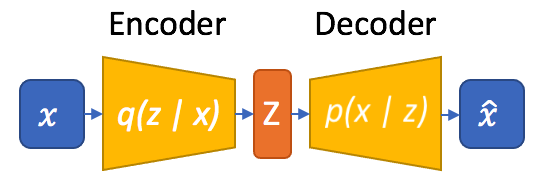

## Reconstruction Error

Left part of the Variational Lower Bound.

$E_{q(z)} \log p(x | z) \propto E_{q(z)} \log p(x | \hat{x})$ because the decoder is deterministic. If we choose a tractable distribution for $p(\cdot)$ such as the Gaussian distribution, our conditional probability will look like:

$$p(x | \hat{x}) = e^{-|x - \hat{x}|^2}$$

And its $\log$ by:

$$\log p(x | \hat{x}) = -|x - \hat{x}|^2$$

Which is the **Mean Squared Error**, aka can our model reconstruct correctly the input.

## KL Divergence

Right part of the Variational Lower Bound.

The right part says that our network-distribution $q(z)$ must match the distribution $p(z)$. Now again, we choose $p(\cdot)$ to follow the Gaussian distribution (with zero mean and unit variance $\mathcal{N}(0, I)$).

Now, we are never going to generate $z$ directly by the encoder (it won't be a distribution), but we are going to generate the parameters of the distribution $q(\cdot)$ assuming it's gaussian.

So our KL will be:

$$KL(\mathcal{N}(\mu, \Sigma) \Vert \mathcal{N}(0, I))$$

With $\mu \in \mathbb{R}^d$ the predicted mean and $\Sigma \in \mathbb{R}^{d \times d}$ the predicted covariance matrix (it's a multi{variate, dimension} gaussian). For simplicity we assume that $\Sigma$ is a diagonal matrix (dimensions are independent) and thus it's only a vector of size $d$.

## Reparametrization Trick


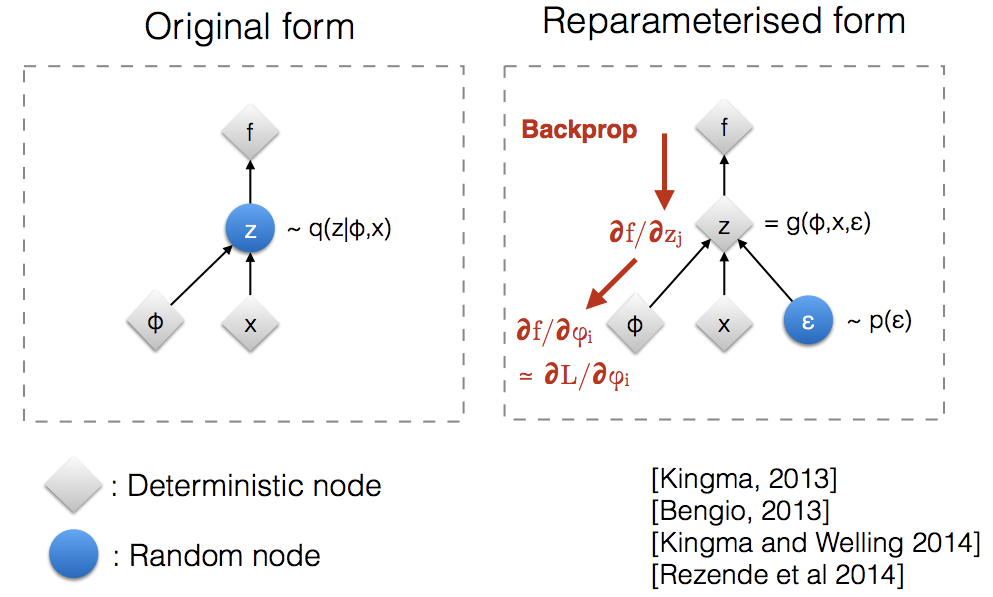

*(previous image from Kingma presentation at 2015 NeurIPS.)*

We now know at our encoder produce a mean and variance vectors. From them, we sample a code $z$ according to a Gaussian distribution. Unfortunately, this sampling is not differentiable, and thus block us from backpropaging through the encoder.

Here comes the **reparametrization trick**. We sample a $\epsilon$ from a Gaussian with zero mean and unit variance and:

$$z = \mu + \epsilon \times \Sigma$$

Which is equivalent from the original sampling we wanted to do. But instead the source of randomness comes from $\epsilon$ which is not in the network graph and don't affect the backpropation.

# Let's code!

The next block of code is the encoder. Try to understand how it works, and then complete the sampling of $z$ using the reparametrization trick.

Note that you must also specify the input dimension of the linear, assuming a grayscale image size of 28x28 and a flatten layer after the convolutions. Quick question, what would be the input dimension of the linear if we had used a global pooling?

In [ ]:
class Encoder(nn.Module):
  def __init__(self, latent_dim=2):
    super().__init__()

    self.latent_dim = latent_dim

    self.enc = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(inplace=True)
    )

    self.fc = nn.Sequential(
        nn.Linear(#TODO, 16),
        nn.ReLU(inplace=True)
    )

    self.fc_mean = nn.Linear(16, latent_dim)
    self.fc_log_var = nn.Linear(16, latent_dim)

  def forward(self, x):
    x = self.enc(x)
    x = x.view(len(x), -1)
    x = self.fc(x)

    mean = self.fc_mean(x)
    # Our encoder computes implicitly the log var
    # instead of the var, in order to avoid using
    # a numerically instable logarithm afterwards.
    log_var = self.fc_log_var(x)

    # TODO: Do the reparametrization trick!
    z = None

    return z, mean, log_var

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/vae/sampling.py
%pycat sampling.py

Now we define our decoder using Transpose convolutions. It's another kind of convolutios that can enlarge my spatial dimensions. While dilated convolutions added padding inside the kernel, transpose convolutions add padding inside the input. The latter is better but also use more memory, which is not really a problem on MNIST.

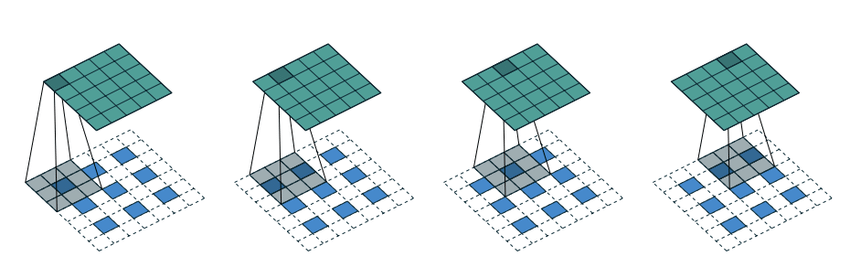

First, play a bit with the parameters (kernel size, stride, and padding) of the transpose convolution to get intuition how it works.

In [ ]:
fake_tensors = torch.randn(2, 1, 1, 1)  # fake images of size 1x1

nn.ConvTranspose2d(1, 1, kernel_size=5, stride=2, padding=0)(fake_tensors).shape

Now try to understand the decoder:

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_dim=2):
    super().__init__()

    self.fc = nn.Sequential(
        nn.Linear(2, 64),
        nn.ReLU(inplace=True)
    )

    self.dec = nn.Sequential(
        nn.ConvTranspose2d(64, 64, kernel_size=5, stride=2, padding=0),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=0),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=0),
    )

  def forward(self, x):
    x = self.fc(x)
    x = x.view(len(x), 64, 1, 1)
    x = self.dec(x)
    return x

And complete the VAE!

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()

    # TODO

  def forward(self, x):
    # TODO

    # returns:
    # - the reconstructed images `xhat`
    # - the predicted mean `mean`
    # - the predicted variance `log_var`
    return xhat, mean, log_var


VAE()(torch.randn(1, 1, 28, 28))[0].shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/vae/vae.py
%pycat vae.py

You now have to code our two losses:

1. Reconstruction Error which is the Mean Squared Error:

$$\log p(x | \hat{x}) \propto -|x - \hat{x}|^2$$

Don't use the predefined Mean Squared Error by PyTorch by code it yourself. But you can check your results against the official version.

*NB: you could also have used a binary cross-entropy with sigmoid, see the math rational [here](https://www.expunctis.com/2019/01/27/Loss-functions.html).*

2. KL Divergence

Gaussian distribution is tractable, allowing us to have a closed form (i.e. direct solution) of the KL divergence between our network distribution $\mathcal{N}(\mu, \Sigma)$ and a zero-mean unit-variance Gaussian $\mathcal{N}(0, I)$.

The whole derivation can be found [here](https://stats.stackexchange.com/a/370048), but the final result is:

$$KL(\mathcal{N}(\mu, \Sigma), \mathcal{N}(0, I)) = \frac{1}{2} [ - 1 -\sum_i \log \Sigma_{i,i}^2 + \sum_i \Sigma_{i,i}^2 + \sum_i \mu_i^2]$$


# Overall

Don't forget that we wanted to maximize the variational lower bound:

$$\mathcal{L} = E_{q(z)} \log p(x | \hat{x}) - KL(q(z) \Vert p(z))$$

But as commonly done in optimization, it's easier to minimize the inverse (i.e. $-\mathcal{L}$). Beware of the sign! You really don't want to have negative losses...

Code the losses:


In [ ]:
def reconstruction(xhat, x):
  # TODO


# You should get 1652.1230
torch.manual_seed(1)
reconstruction(torch.randn(2, 1, 28, 28), torch.randn(2, 1, 28, 28))

In [ ]:
def kl_div_gauss(log_var, mean):
    # TODO


# You should get 7.7992
torch.manual_seed(1)
kl_div_gauss(torch.randn(2, 10), torch.randn(2, 10))

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/vae/losses.py
%pycat losses.py

For now, try with $\beta = 1$, the default setting of VAE.

In [ ]:
epochs = 30
beta = 1.0

net = VAE().cuda()
optimizer = torch.optim.Adam(net.parameters())

for epoch in range(epochs):
  _recon, _kl = 0., 0.
  c = 0

  for x, _ in loader:
    x = x.cuda()

    optimizer.zero_grad()
    xhat, mean, log_var = net(x)

    recon_loss = reconstruction(xhat, x)
    kl_loss = kl_div_gauss(log_var, mean)

    loss = recon_loss + beta * kl_loss
    loss.backward()
    optimizer.step()

    _recon += recon_loss.item()
    _kl += kl_loss.item()
    c += 1

  _recon = round(_recon / c, 5)
  _kl = round(_kl / c, 5)

  print(f"Epoch {epoch}; recon: {_recon}; kl: {_kl}")

Let's visualize the reconstruction of some digits. Bear in mind, that the $28 \times 28 = 784$ pixels images have been compressed at some point to two vectors of $2$ dimensions.

In [ ]:
indexes = [0, 42, 1337, 9642, 934]

plt.figure(figsize=(10, 8))
for i, index in enumerate(indexes):
  x = dataset.data[index]

  with torch.no_grad():
    reconstruction, _, _ = net(x[None, None].cuda() / 255)
  reconstruction = torch.clamp(255 * reconstruction[0], min=0, max=255)
  reconstruction = reconstruction.cpu().numpy()

  ax = plt.subplot(len(indexes), 2, i * 2 + 1)
  ax.axis("off")
  ax.set_title("Original")
  ax.imshow(x, cmap="Greys_r")
  ax = plt.subplot(len(indexes), 2, i * 2 + 2)
  ax.axis("off")
  ax.set_title("Reconstruction")
  ax.imshow(reconstruction[0], cmap="Greys_r")

The results may be a bit blurry. We could have sharper results with more epochs or by using a binary cross-entropy with sigmoid, but at least we see that the model has learned something.

Now, what if I'm interpolating the latent space, to generate novel --never seen before-- digits?

In [ ]:
@torch.no_grad()
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n), dtype=np.uint8)
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor(np.array([[xi, yi]]))
            x_decoded = torch.clamp(255 * vae.dec(z_sample.cuda().float()).cpu(), min=0, max=255).numpy().astype(np.uint8)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(net)

You can see that thanks to our KL loss the latent space is smooth: We don't go from the digit "1" to the digits "8" directly.

Because our latent space dimensions are only 2, we can directly plot the codes on a graph without needing dimensionaly reduction tools like PCA or T-SNE.

In [ ]:
@torch.no_grad()
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    _, z_mean, _ = vae.enc(data.cuda().float() / 255)
    z_mean = z_mean.cpu().numpy()
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


x_train, y_train = dataset.data, dataset.targets.numpy()
x_train = x_train[:, None]

plot_label_clusters(net, x_train, y_train)


Let's visualize the pairwise relationship of the dimensions of our latent codes.

The following code will plot a $d \times d$ matrix. In the diagonal we see the distribution of a dimension. Outside the diagonal, we see the relation with other dimensions.

If you train with a $\beta$ value high enough (try higher than 10), you should see that all dimensions are perfectly disentangled.

In [ ]:
import pandas as pd
import seaborn as sns


with torch.no_grad():
  _, z_mean, _ = net.enc(dataset.data.cuda().float()[:, None] / 255)
df_zs = pd.DataFrame(z_mean.cpu().numpy())

pairplot = sns.pairplot(df_zs)
pairplot.set(xlim=(-3,3), ylim = (-3,3))

- Try to make a link between what you see on this previous figure and the latent space interpolation figure!
- Retrain the VAE with very low value of $\beta$, how is the reconstruction? How is the interpolation in the latent space?
- Retrain the VAE with very high value of $\beta$, how is the reconstruction? How is the interpolation in the latent space?